In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("arxiv_embeddings.csv")
print(df.columns)

Index(['id', 'title', 'categories', 'title_tokenized', 'categories_tokenized',
       'categories_vectors'],
      dtype='object')


In [3]:
titles = []

for a in df['title']:
    titles.append(a)

In [4]:
import re

import numpy as np

from east.asts import base


def clear_text(text, lowerize=True):

    pat = re.compile(r'[^A-Za-z0-9 \-\n\r.,;!?А-Яа-я]+')
    cleared_text = re.sub(pat, ' ', text)

    if lowerize:
        cleared_text = cleared_text.lower()

    tokens = cleared_text.split()
    return tokens


def make_substrings(tokens, k=4):

    for i in range(max(len(tokens) - k + 1, 1)):
        yield ' '.join(tokens[i:i + k])


def get_relevance_matrix(texts, strings):

    matrix = np.empty((0, len(strings)), float)
    prepared_text_tokens = [clear_text(t) for t in texts]

    prepared_string_tokens = [clear_text(s) for s in strings]
    prepared_strings = [' '.join(t) for t in prepared_string_tokens]

    for text_tokens in prepared_text_tokens:
        ast = base.AST.get_ast(list(make_substrings(text_tokens)))
        row = np.array([ast.score(s) for s in prepared_strings])
        matrix = np.append(matrix, [row], axis=0)

    return matrix


def save_matrix(matrix):
    np.savetxt("relevance_matrix.txt", matrix)

In [6]:
with open("taxonomy_leaves.txt") as f:
    strings = [l.strip() for l in f.readlines()]

In [8]:
relevance_matrix = get_relevance_matrix(titles[:1500], strings)

In [9]:
save_matrix(relevance_matrix)

In [14]:
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib import pyplot as plt

In [10]:
class T2FCM: 
  def __init__(self, X, k, options):
    self.expo_lower = options[0]
    self.expo_upper = options[1]
    max_iter = options[2]
    min_impro = options[3]
    display = options[4]

    data_n = np.size(X, 0);
    self.obj_fcn = []

    U_lower= np.random.rand(k, data_n)
    col_sum_lower = np.sum(U_lower, axis=0)
    U_lower =np.divide(U_lower, col_sum_lower)
    U_upper = np.random.rand(k, data_n) 
    col_sum_upper = np.sum(U_upper, axis=0)
    U_upper = np.divide(U_upper, col_sum_upper)

    for i in range(0, max_iter):
          mf_lower = np.power(U_lower, self.expo_lower);
          mf_upper = np.power(U_upper,self.expo_upper);

          self.center_lower = np.divide(mf_lower@X,(np.sum(mf_lower,axis=1))[:,None]);
          self.center_upper = np.divide(mf_upper@X,(np.sum(mf_upper,axis=1))[:,None]);

          dist_lower = euclidean_distances(self.center_lower, X);
          dist_upper = euclidean_distances(self.center_upper, X);
          
          tmp_lower = np.power(dist_lower,(-2/(self.expo_lower-1)));
          U_m1 = np.divide(tmp_lower, np.sum(tmp_lower,axis=0));
          tmp_upper = np.power(dist_upper,(-2/(self.expo_upper-1)));
          U_m2 = np.divide(tmp_upper,np.sum(tmp_upper,axis=0));    
          
          U_lower = np.minimum(U_m1,U_m2);
          U_upper = np.maximum(U_m1,U_m2);
          U = np.mean(np.array([U_lower,U_upper]), axis=0);
          mf = np.power(U,((self.expo_lower+self.expo_upper)/2))

          self.center = np.mean(np.array([self.center_lower,self.center_upper]), axis=0);
          dist = euclidean_distances(self.center, X)
          self.obj_fcn.append(np.sum(np.multiply(np.power(dist,2),mf)))

           

  def MF_Compute(self, X):
    dist_lower = euclidean_distances(self.center_lower, X);
    print(self.center_lower)
    print(X)
    dist_upper = euclidean_distances(self.center_upper, X);
    
          
    tmp_lower = np.power(dist_lower,(-2/(self.expo_lower-1)));
    U_m1 = np.divide(tmp_lower, np.sum(tmp_lower,axis=0));
    tmp_upper = np.power(dist_upper,(-2/(self.expo_upper-1)));
    U_m2 = np.divide(tmp_upper,np.sum(tmp_upper,axis=0));    
          
    U_lower = np.minimum(U_m1,U_m2);
    U_upper = np.maximum(U_m1,U_m2);
    U = np.mean(np.array([U_lower,U_upper]), axis=0);
    mf = np.power(U,((self.expo_lower+self.expo_upper)/2))
    return mf

  def predict(self, tst): 
    dist = euclidean_distances(self.center, tst)
    mf = self.MF_Compute(tst)
    pred= np.multiply(np.power(dist,2),mf)
    return pred

[[0.12059659 0.13246968 0.10213072 ... 0.16146215 0.09810026 0.14174209]
 [0.10557846 0.11286283 0.10128963 ... 0.13426767 0.09350745 0.10968517]
 [0.10559162 0.11288107 0.10129147 ... 0.13429308 0.09351214 0.10971367]]
[[0.16612202 0.14682746 0.07035818 ... 0.24566867 0.10412033 0.29437873]
 [0.16085114 0.12599638 0.11464646 ... 0.12851563 0.08531746 0.12877604]
 [0.08043448 0.12217257 0.10076248 ... 0.15067566 0.06969176 0.13442662]
 ...
 [0.08583774 0.10745316 0.09463981 ... 0.11645072 0.04902425 0.13513014]
 [0.14300506 0.14101785 0.08572132 ... 0.23290413 0.09907521 0.09556238]
 [0.08024342 0.1385186  0.13299347 ... 0.19809204 0.09933694 0.05991862]]


array([0, 0, 0, ..., 1, 0, 1])

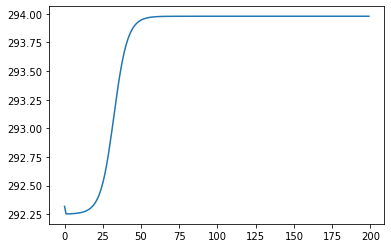

In [15]:
k=3
opts = [1.5 , 2.5 , 200 , 1e-5, 0]
ob = T2FCM(relevance_matrix, k, opts)
plt.plot(ob.obj_fcn)
dec = ob.predict(relevance_matrix)
np.argmax(dec, axis=0)

In [18]:
np.savetxt("clusters.dat", dec)

In [1]:
!python3 pargenfs.py Data_Science_taxonomy.csv taxonomy_leaves.txt clusters.dat 0

Number of leaves: 351
All positive weights:
sample complexity and generalization bounds                  0.84665
unsupervised learning and clustering                         0.37642
boolean function learning                                    0.37615
After transformation:
sample complexity and generalization bounds                  0.84665
unsupervised learning and clustering                         0.37642
boolean function learning                                    0.37615
Setting weights for internal nodes
Membership in root: 1.00000
Pruning tree...
Setting gaps...
Other parameters setting...
ParGenFS main steps...
Done. Saving...
Table saved in the file: table.csv
ete representation saved in the file: taxonomy_tree_lifted.ete
ete representation saved.
Done.


In [2]:
!python3 pargenfs.py Data_Science_taxonomy.csv taxonomy_leaves.txt clusters.dat 1

Number of leaves: 351
All positive weights:
sample complexity and generalization bounds                  0.67562
unsupervised learning and clustering                         0.52144
boolean function learning                                    0.52119
After transformation:
sample complexity and generalization bounds                  0.67562
unsupervised learning and clustering                         0.52144
boolean function learning                                    0.52119
Setting weights for internal nodes
Membership in root: 1.00000
Pruning tree...
Setting gaps...
Other parameters setting...
ParGenFS main steps...
Done. Saving...
Table saved in the file: table.csv
ete representation saved in the file: taxonomy_tree_lifted.ete
ete representation saved.
Done.


In [3]:
!python3 pargenfs.py Data_Science_taxonomy.csv taxonomy_leaves.txt clusters.dat 2

Number of leaves: 351
All positive weights:
sample complexity and generalization bounds                  0.58502
unsupervised learning and clustering                         0.57356
boolean function learning                                    0.57339
After transformation:
sample complexity and generalization bounds                  0.58502
unsupervised learning and clustering                         0.57356
boolean function learning                                    0.57339
Setting weights for internal nodes
Membership in root: 1.00000
Pruning tree...
Setting gaps...
Other parameters setting...
ParGenFS main steps...
Done. Saving...
Table saved in the file: table.csv
ete representation saved in the file: taxonomy_tree_lifted.ete
ete representation saved.
Done.
